In [26]:
import numpy as np
import pandas as pd
import cufflinks as cf
import plotly.offline as plyo
import matplotlib.pyplot as plt
csfont = {'fontname':'Times New Roman'}
import hdbscan
import seaborn as sns
from numba import jit
from pathlib import Path
from scipy.spatial import distance_matrix

In [2]:
def read_bl2(path):
    return np.core.records.fromfile(str(path),formats='f8,(2048)i2,f8,(2048)i2',names='tstamp,pwave,ptime,wave')

In [3]:
saturatedData = np.array(np.arange(2048))
# List all files in directory using pathlib
basepath = Path("/Users/elicarter/Local/FominResearch/RealData/Runs/s_1000")
files_in_basepath = (entry for entry in basepath.iterdir() if entry.is_file())
for item in files_in_basepath:
    if str(item).endswith(".dat"):
        print("Adding " + str(item))
        saturatedData = np.vstack((saturatedData, read_bl2(item)["wave"]))
saturatedData = np.delete(saturatedData, [0], 0) #delete the placeholder shape row

Adding /Users/elicarter/Local/FominResearch/RealData/Runs/s_1000/s_1000_r_000010_1.dat
Adding /Users/elicarter/Local/FominResearch/RealData/Runs/s_1000/s_1000_r_000050_1.dat
Adding /Users/elicarter/Local/FominResearch/RealData/Runs/s_1000/s_1000_r_000090_1.dat
Adding /Users/elicarter/Local/FominResearch/RealData/Runs/s_1000/s_1000_r_000070_1.dat
Adding /Users/elicarter/Local/FominResearch/RealData/Runs/s_1000/s_1000_r_000020_1.dat
Adding /Users/elicarter/Local/FominResearch/RealData/Runs/s_1000/s_1000_r_000001_1.dat


In [4]:
#delete all data that goes over 30,000 as it's pre amp saturated
data = np.copy(saturatedData)
over30k = False
#iterate backwards to avoid index proboems with removing
for i in range(len(saturatedData)-1,-1,-1):
    for j in range(len(saturatedData[0])-1,-1,-1):
        if (saturatedData[i,j] > 30000):
            data = np.delete(data, i, axis=0)
            break

In [5]:
np.random.shuffle(data)

In [6]:
print(np.shape(saturatedData))
print(np.shape(data))

(8590, 2048)
(8554, 2048)


In [7]:
colors = {}
colors[-1] = 'black'
colors[0] = 'r'
colors[1] = 'g'
colors[2] = 'b'
colors[3] = 'c'
colors[4] = 'm'
colors[5] = 'y'
colors[6] = 'pink'
colors[7] = 'purple'
colors[8] = 'silver'
colors[9] = 'brown'
colors[10] = 'olive'
colors[11] = 'aquamarine'
colors[12] = 'cornflowerblue'
colors[13] = 'teal'
colors[14] = 'salmon'
colors[15] = 'lime'
colors[16] = 'gold'

# Dimensionality Reduction using principal component analysis

In [8]:
u, s, vh = np.linalg.svd(data, full_matrices=False)

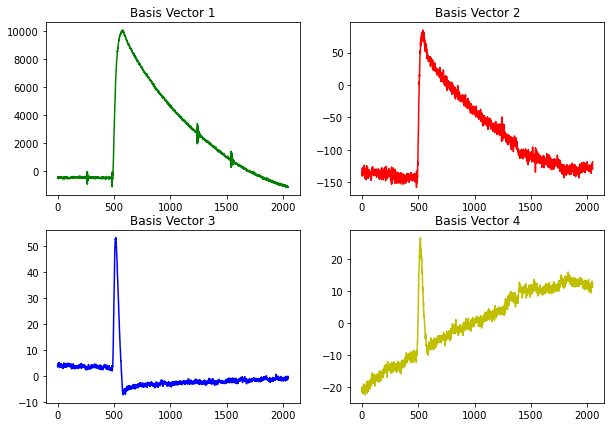

In [9]:
fig, ax = plt.subplots(2,2, figsize = (10,7))
ax[0,0].plot(u[0,0]*s[0]*vh[0], color = 'g')
ax[0,0].title.set_text("Basis Vector 1")
ax[0,1].plot(u[1,1]*s[1]*vh[1], color = 'r')
ax[0,1].title.set_text("Basis Vector 2")
ax[1,0].plot(u[2,2]*s[2]*vh[2], color = 'b')
ax[1,0].title.set_text("Basis Vector 3")
ax[1,1].plot(u[3,3]*s[3]*vh[3], color = 'y')
ax[1,1].title.set_text("Basis Vector 4")

use scree plot and percent variance to find where we should make the cut on demensions

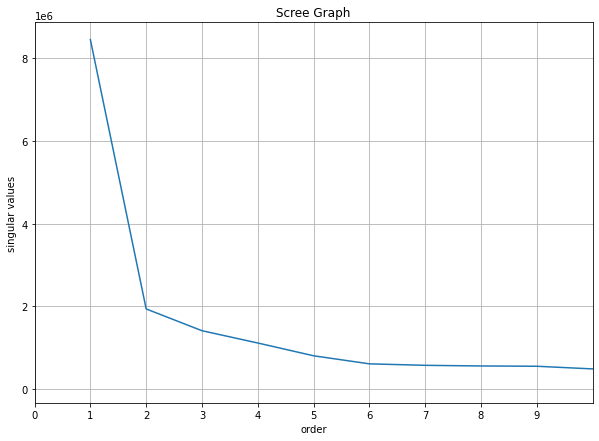

In [10]:
scree_order = np.arange(1,len(s)+1)
fig, ax = plt.subplots(1, 1, figsize = (10,7))
ax.plot(scree_order, s)
ax.title.set_text("Scree Graph")
ax.set_ylabel("singular values")
ax.set_xlabel("order")
ax.set_xlim([0,10])
ax.set_xticks(np.arange(0,10))
plt.grid()
plt.show()

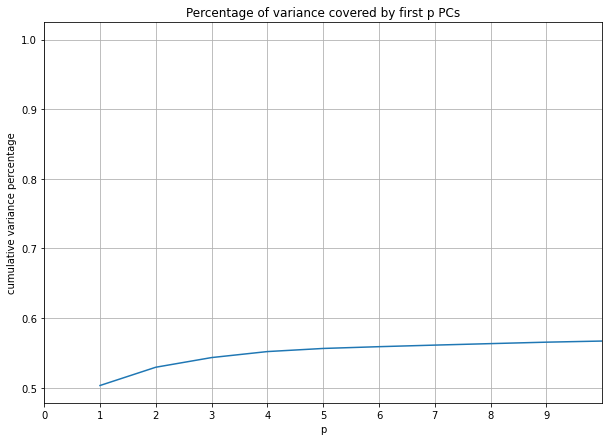

In [11]:
variance = np.zeros_like(s)
for i in range(len(s)):
    variance[i] = s[i]**2
total_variance = 0
for i in range(len(variance)):
    total_variance += variance[i]
    
pvc = np.zeros_like(variance)
for i in range(len(pvc)):
    pvc[i] = variance[i] + pvc[i-1]
for i in range(len(pvc)):
    pvc[i] = pvc[i] / total_variance
    
fig, ax = plt.subplots(1, 1, figsize = (10,7))
ax.plot(scree_order, pvc)
ax.title.set_text('Percentage of variance covered by first p PCs')
ax.set_xlabel('p')
ax.set_ylabel('cumulative variance percentage')
ax.set_xlim(0,10)
ax.set_xticks(np.arange(0,10))
plt.grid()
plt.show()

In [12]:
v = np.transpose(vh)
v2D = v[:,:2]
rData2D = data@v2D

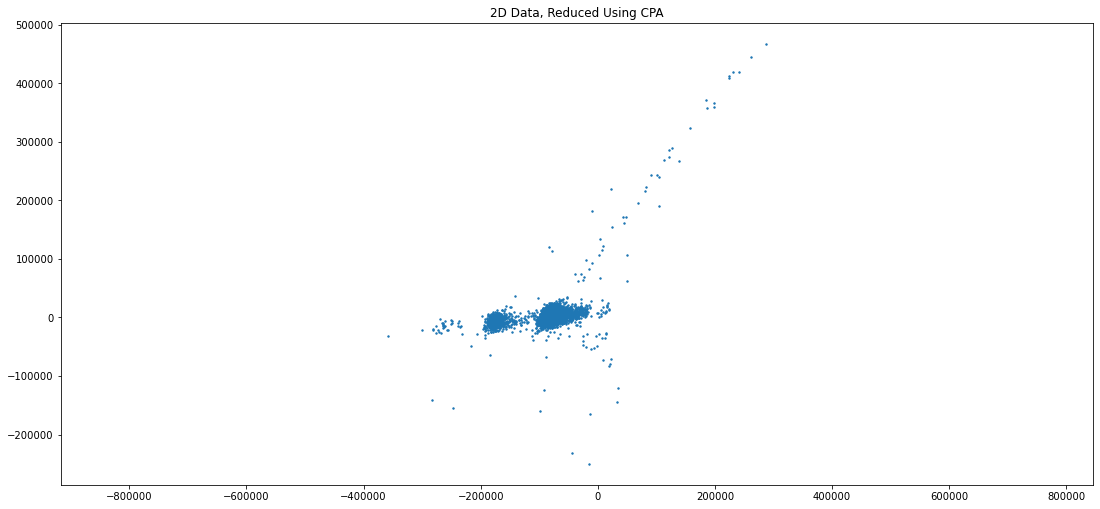

In [16]:
plt.scatter(rData2D[:,0], rData2D[:,1], s=2)
plt.axis("equal")
fig = plt.title("2D Data, Reduced Using CPA")
fig = plt.gcf()
fig.set_size_inches(18.5, 8.5)

# Start HDBScan

In [17]:
doubleDistances2 = distance_matrix(rData2D, rData2D)
#double counts distances. Get upper triangle matrix then manipulate it 
temp2 = np.triu(doubleDistances2)
distances2 = np.asarray(temp2).reshape(-1)
distances2 = np.sort(distances2)
distances2 = np.flip(distances2)
#remove 0s where repeats used to be
nonzeros = int((len(doubleDistances2)*len(doubleDistances2) - 1)/2)
distances2 = distances2[0:nonzeros]
order = np.arange

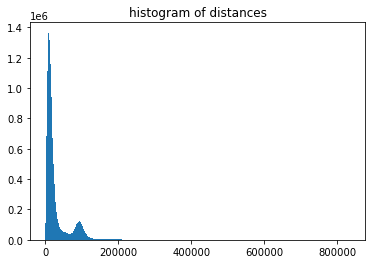

In [18]:
plt.title("histogram of distances")
fig11 = plt.hist(distances2, 1000)

In [19]:
hdb2 = hdbscan.HDBSCAN(min_cluster_size=20, cluster_selection_epsilon = 7750, gen_min_span_tree=True).fit(rData2D)
labels2 = hdb2.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters2 = len(set(labels2)) - (1 if -1 in labels2 else 0)
n_noise2 = list(labels2).count(-1)

counts2 = np.zeros(n_clusters2)
for i in range(n_clusters2):
    for label in labels2:
        if label == i:
            counts2[i] += 1

In [20]:
print ("Number of clusters: " + str(n_clusters2))
print ("Number of noise points: " + str(n_noise2))
print ("% of data included in clustering: " + str (1 - n_noise2/len(labels2)))

Number of clusters: 3
Number of noise points: 87
% of data included in clustering: 0.9898293196165536


In [21]:
percentage_counts2 = counts2/len(data)
for i in range(len(percentage_counts2)):
    percentage_counts2[i] = round(percentage_counts2[i], 3)

<AxesSubplot:>

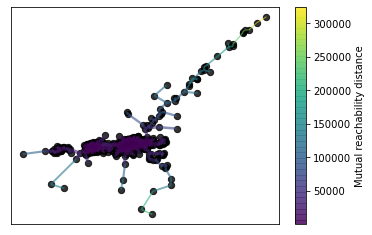

In [22]:
hdb2.minimum_spanning_tree_.plot(edge_cmap='viridis',
                                      edge_alpha=0.6,
                                      node_size=40,
                                      edge_linewidth=1)

<AxesSubplot:ylabel='$\\lambda$ value'>

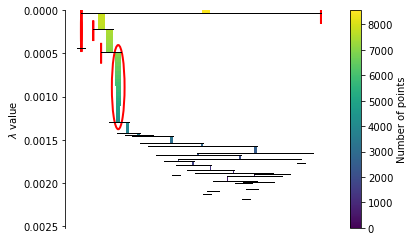

In [23]:
hdb2.condensed_tree_.plot(select_clusters=True)

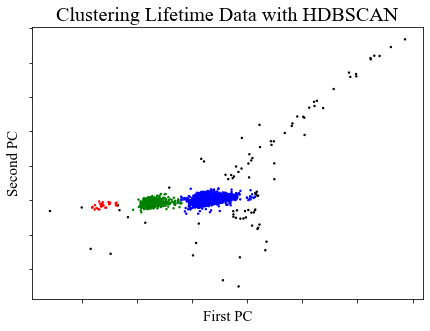

In [27]:
cvec = [colors[label] for label in labels2]
fig, ax = plt.subplots(figsize = (7,5))
scatter = ax.scatter(rData2D[:,0], rData2D[:,1], s=2, c=cvec, cmap='turbo')
ax.set_title('Clustering Lifetime Data with HDBSCAN', fontdict=csfont, size=20)
ax.set_xlabel('First PC', **csfont, size=15)
ax.set_ylabel('Second PC', **csfont, size=15)
ax.set_yticklabels([])
ax.set_xticklabels([])

plt.savefig('Clustered_Lifetime_RData_HDBSCAN.png')

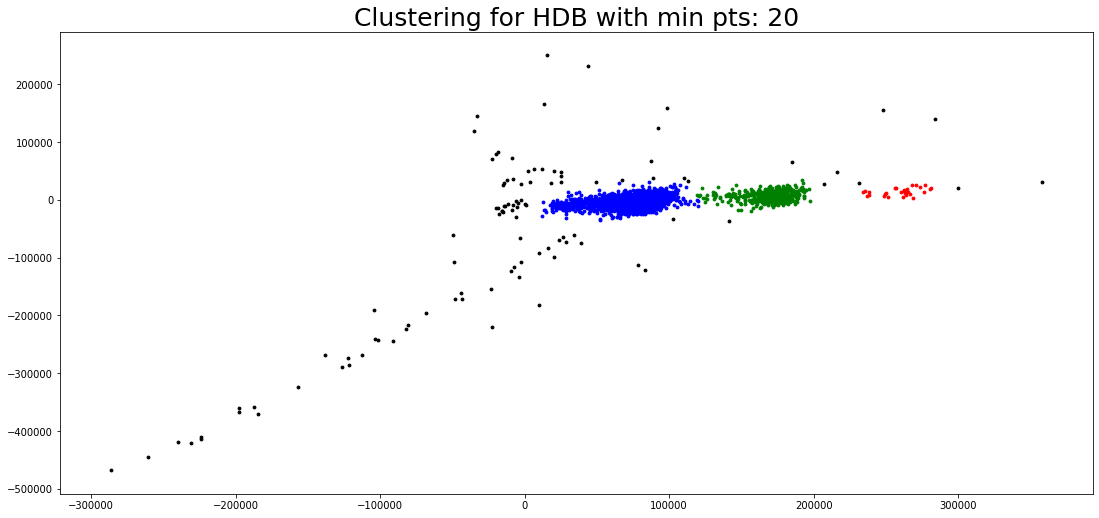

In [59]:
cvec = [colors[label] for label in labels2]
x = rData2D[:,0]
y = rData2D[:,1]
for i in range(len(labels2)): #NOTE: not nessecaryily all data being plotted
    plt.scatter(x[i],y[i], c = cvec[i], s=8)
plt.title('Clustering for HDB with min pts: ' + str(hdb2.min_cluster_size), fontsize=25)
fig = plt.gcf()
fig.set_size_inches(18.5, 8.5)

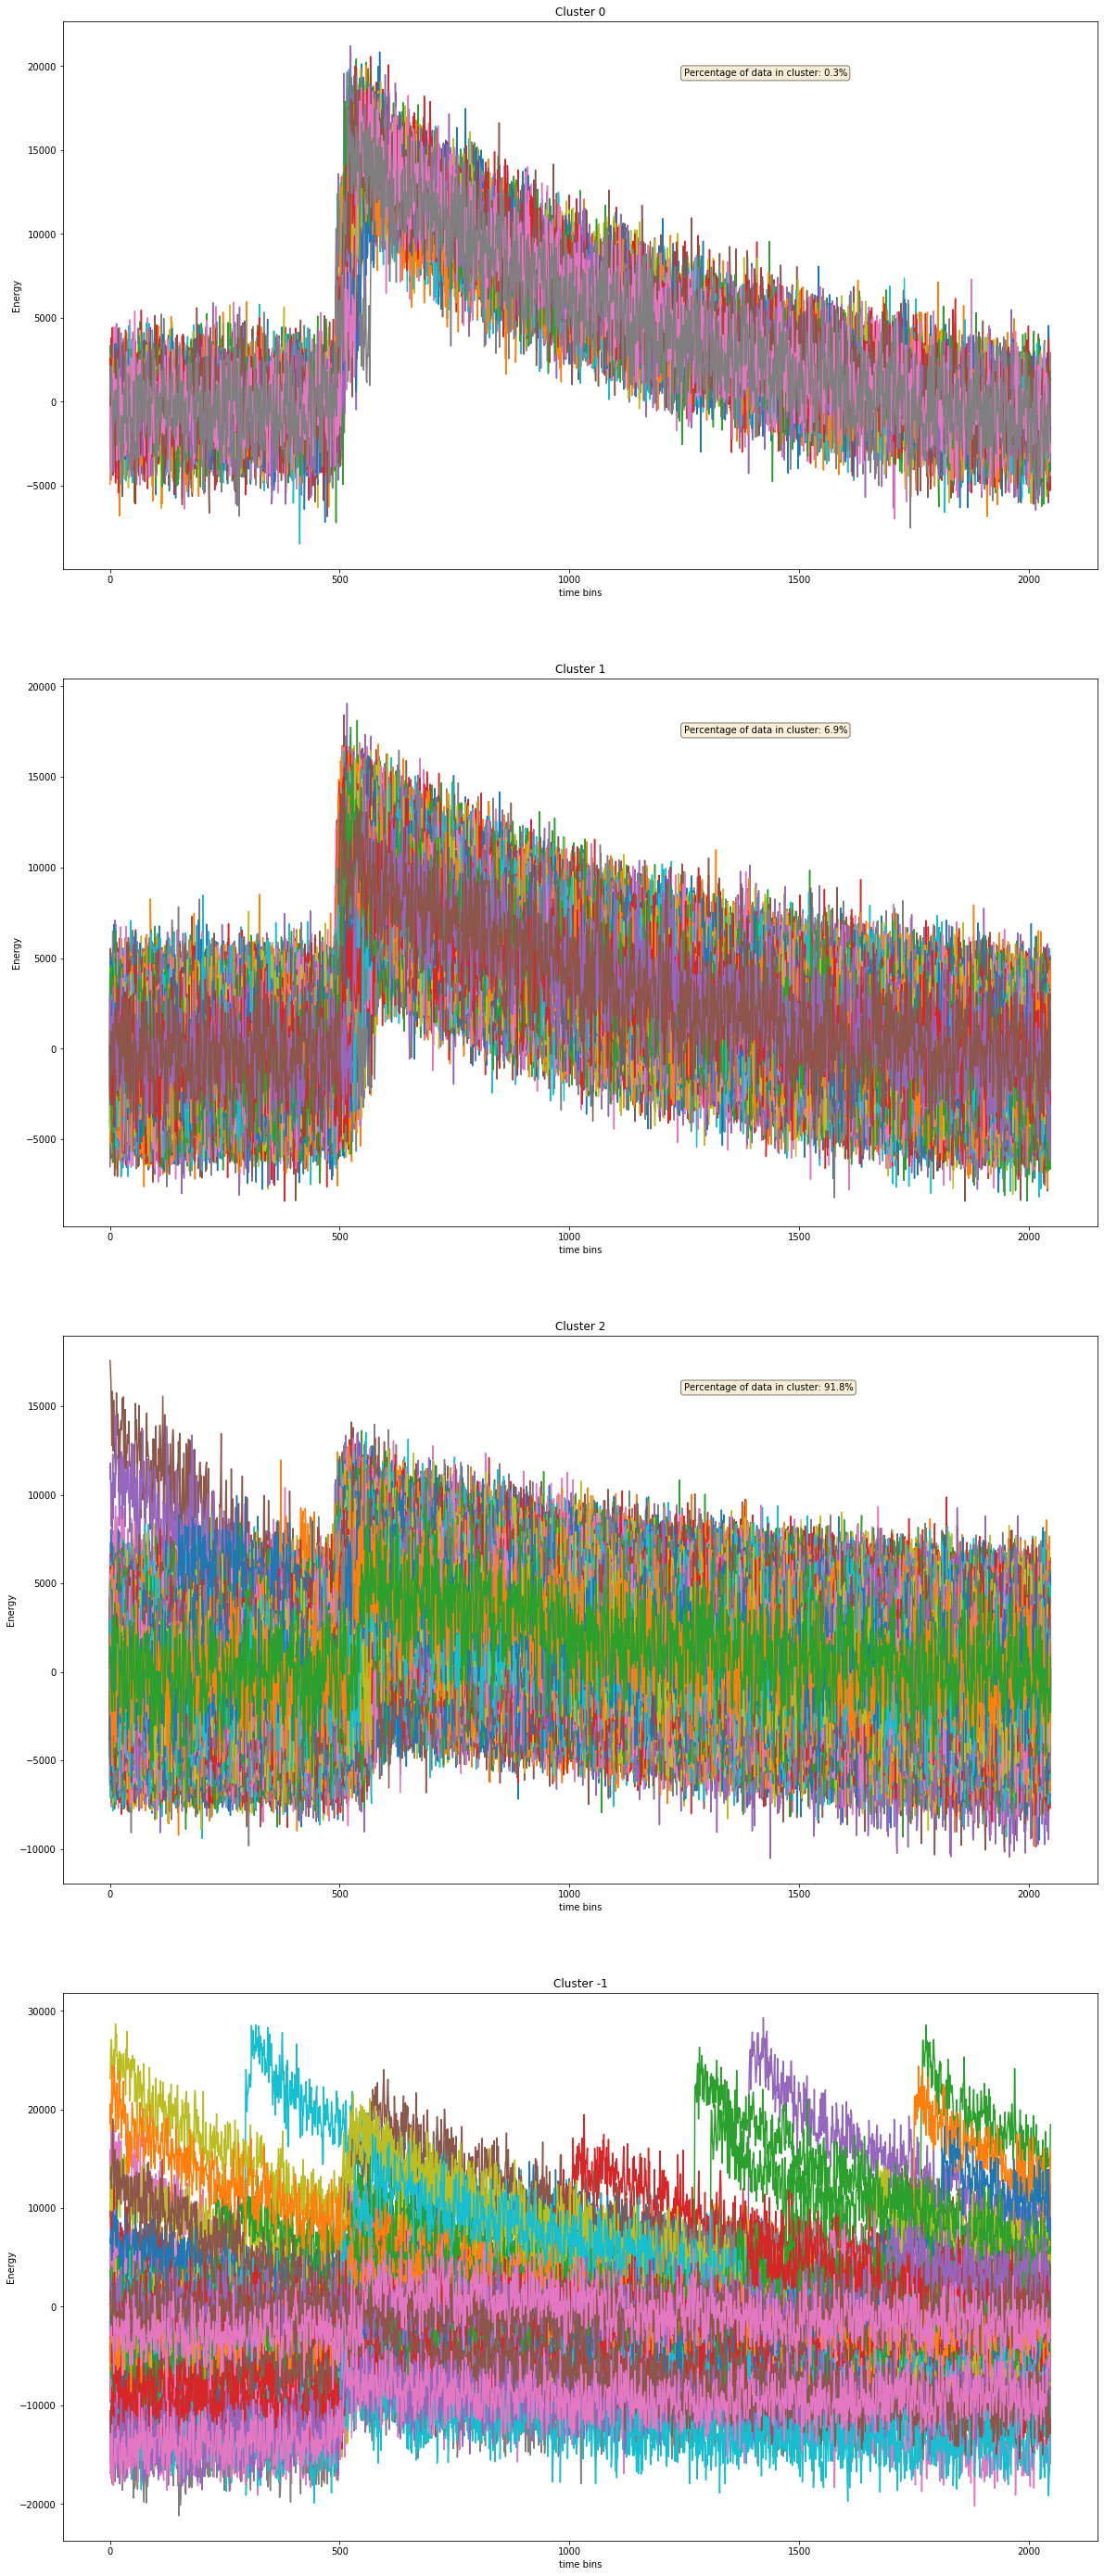

In [22]:
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
fig, ax = plt.subplots(n_clusters2+1, figsize = (20,50))
t = np.arange(2048)
unclustered2D = np.array(np.arange(2048))
for n in range(len(labels2)):
    for i in range(-1, n_clusters2):
        if i == labels2[n]:
            ax[i].plot(t, data[n])
            ax[i].title.set_text("Cluster " + str(i))
            ax[i].set_xlabel("time bins")
            ax[i].set_ylabel("Energy")
for i in range(n_clusters2):
        text_x = ax[i].get_xlim()[1] - 0.4*(ax[i].get_xlim()[1] - ax[i].get_xlim()[0])
        text_y = ax[i].get_ylim()[1] - 0.1*(ax[i].get_ylim()[1] - ax[i].get_ylim()[0])
        ax[i].text(text_x, text_y, "Percentage of data in cluster: " + str(round(100*percentage_counts2[i], 3)) + "%", bbox = props)
plt.show()

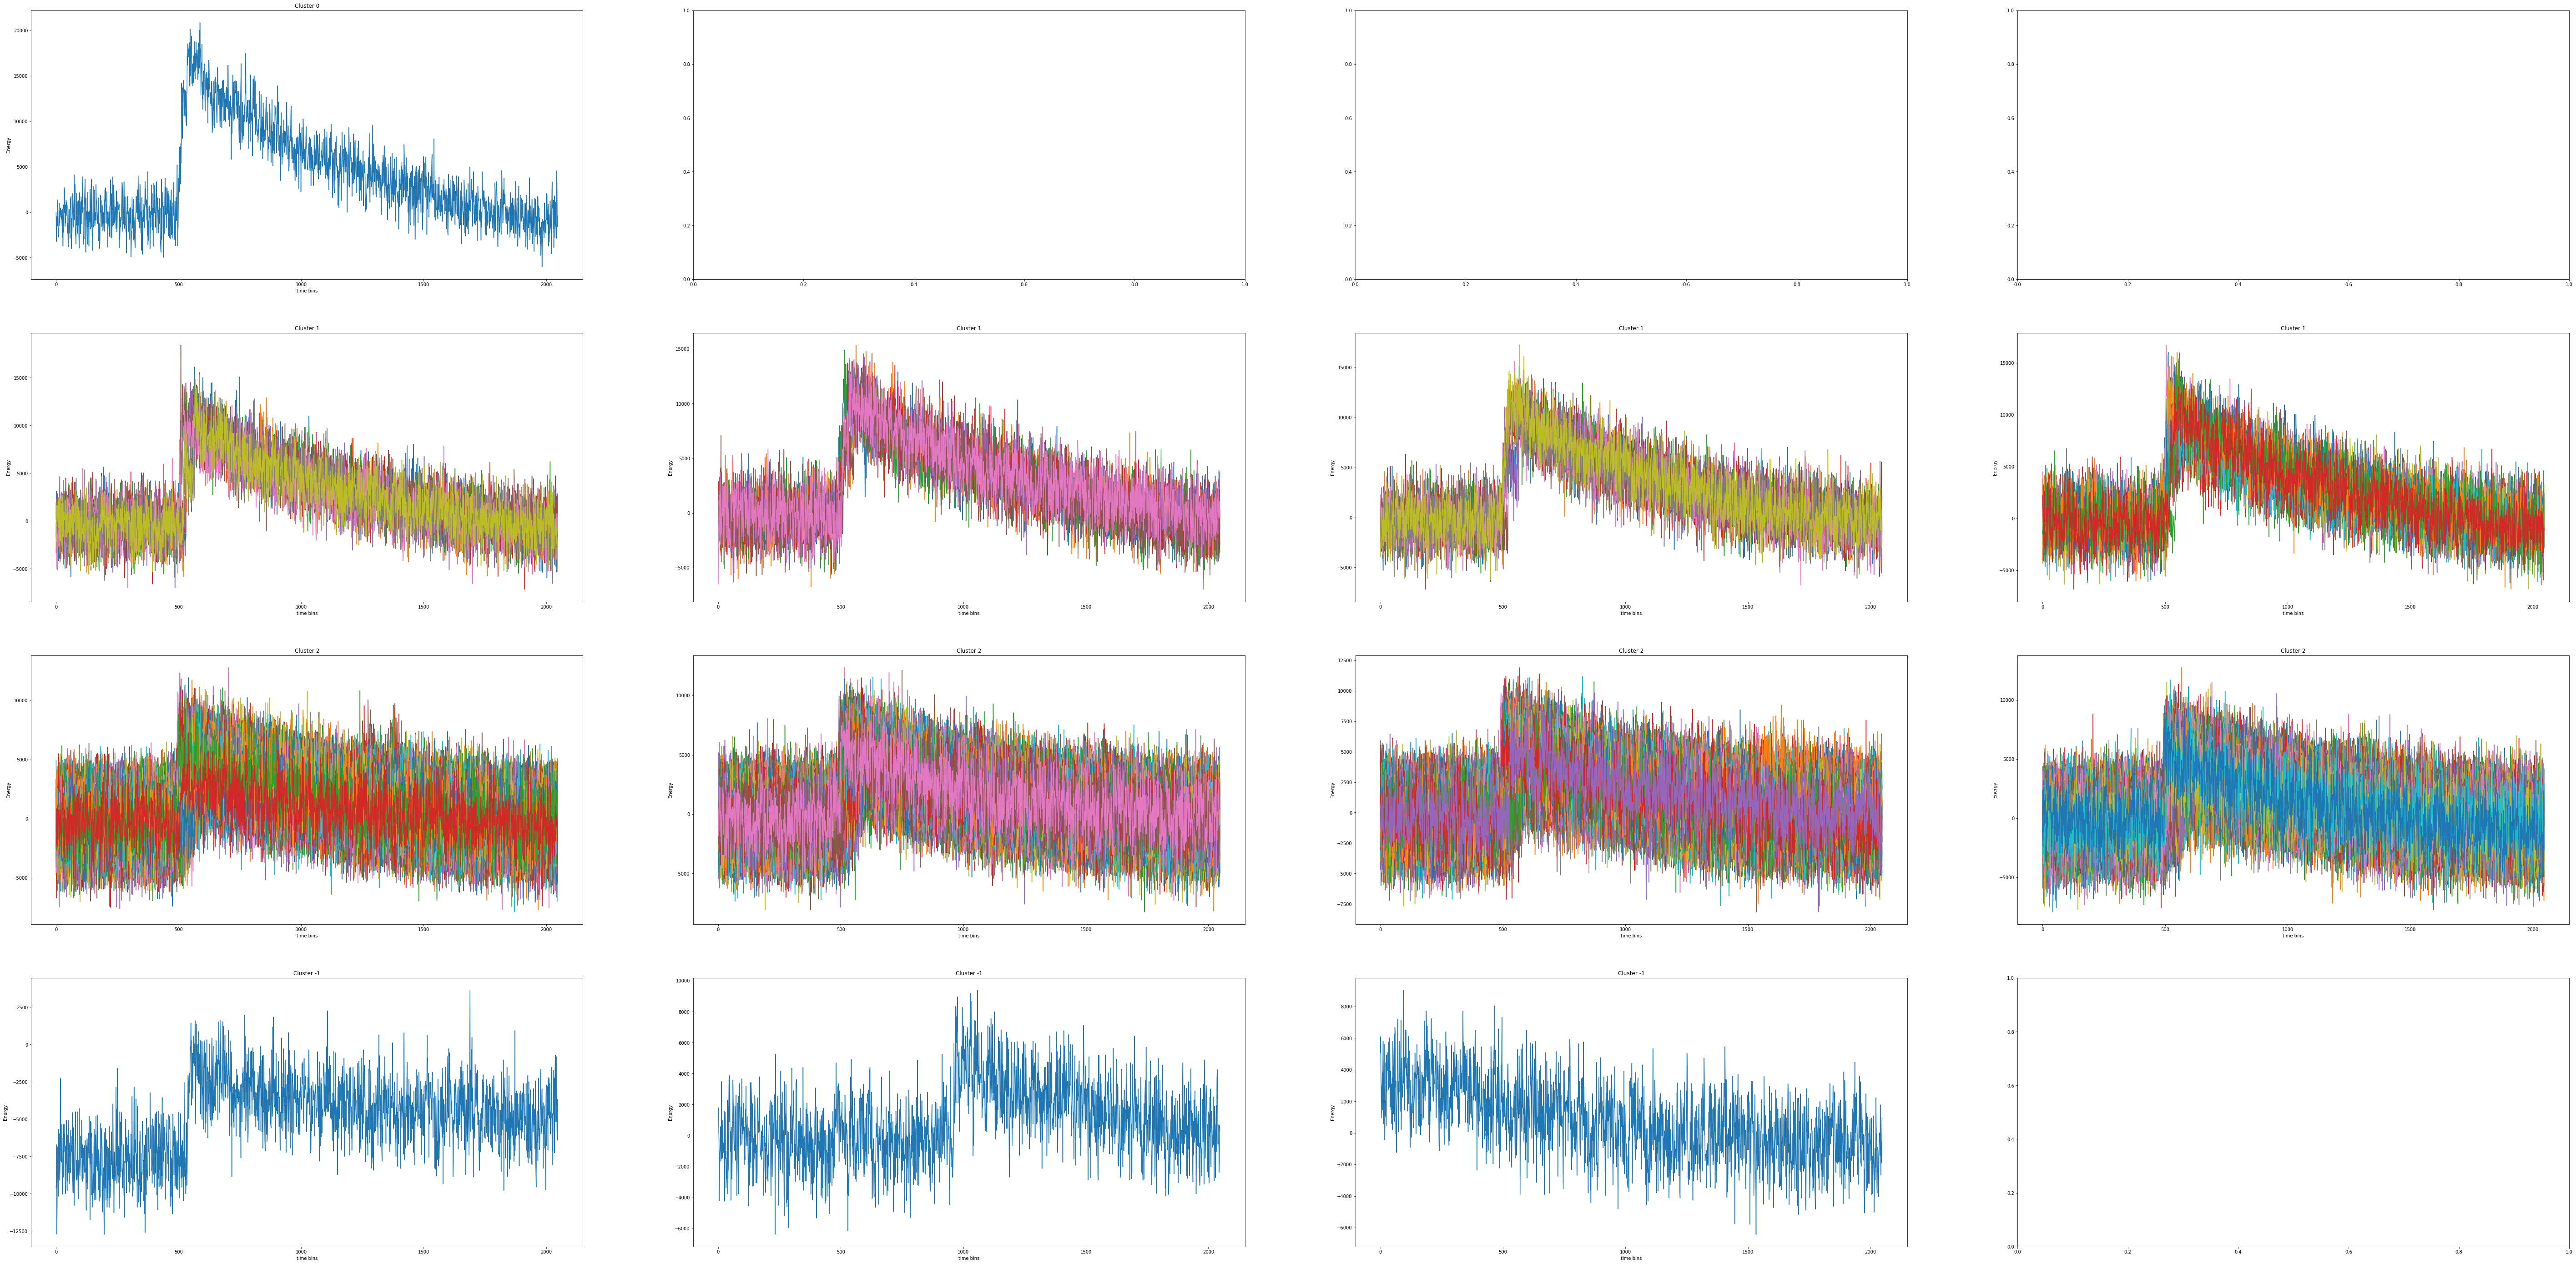

In [23]:
#Plot each group in 4 plots
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
fig, ax = plt.subplots(n_clusters2+1, 4, figsize = (100,50))
t = np.arange(2048)
for j in range(0, 4):
    numPer = int(500 / 4) #NOTE: Not all data is being shown. 500 per column
    for n in range(j*numPer, (j+1)*numPer):
        for i in range(-1, n_clusters2):
            if i == labels2[n]:
                ax[i][j].plot(t, data[n])
                ax[i][j].title.set_text("Cluster " + str(i))
                ax[i][j].set_xlabel("time bins")
                ax[i][j].set_ylabel("Energy")
plt.show()